In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

# Load the raw data
# Create a copy for cleaning
# while handle missing value inorder to Fill missing values or drop rows based on column importance but their were none
# Fix data types
# wanted to remove duplicate but their were none
# Performed Data validation and outlier detection
# CLEANING SUMMARY


In [4]:
df = pd.read_csv('../data//raw/Superstore.csv', encoding='latin1')


In [5]:
# Create a copy for cleaning
df_clean = df.copy()

In [6]:
missing_before = df_clean.isnull().sum().sum()
print(f"Missing values: {missing_before}")

Missing values: 0


In [7]:
# df_clean['Order Date'] = pd.to_datetime(df_clean['Order.Date'])
# df_clean['Ship Date'] = pd.to_datetime(df_clean['Ship.Date'])


date_columns = ['Order.Date', 'Ship.Date']
for col in date_columns:
    if col in df_clean.columns:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
        print(f"Converted {col} to datetime")

Converted Order.Date to datetime
Converted Ship.Date to datetime


In [10]:
duplicates_before = df_clean.duplicated().sum()
duplicates_before

0

In [11]:
# Data validation and outlier detection
print("4. Validating data...")
if 'Sales' in df_clean.columns:
    negative_sales = (df_clean['Sales'] < 0).sum()
    print(f"Negative sales records: {negative_sales}")
    
    # Check for extreme outliers using IQR method
    Q1 = df_clean['Sales'].quantile(0.25)
    Q3 = df_clean['Sales'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_clean[(df_clean['Sales'] < Q1 - 1.5 * IQR) | 
                        (df_clean['Sales'] > Q3 + 1.5 * IQR)]
    print(f"Sales outliers (IQR method): {len(outliers)}")


4. Validating data...
Negative sales records: 0
Sales outliers (IQR method): 5655


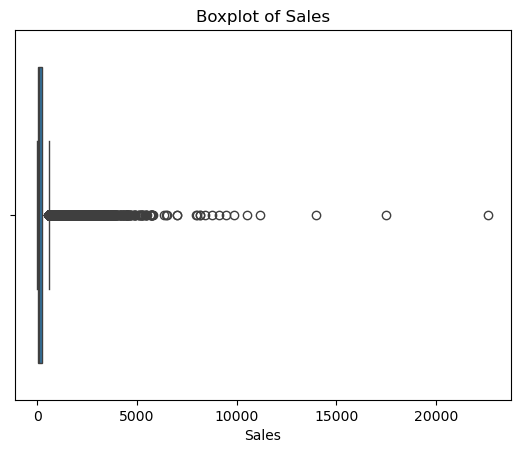

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df_clean['Sales'])
plt.title('Boxplot of Sales')
plt.show()

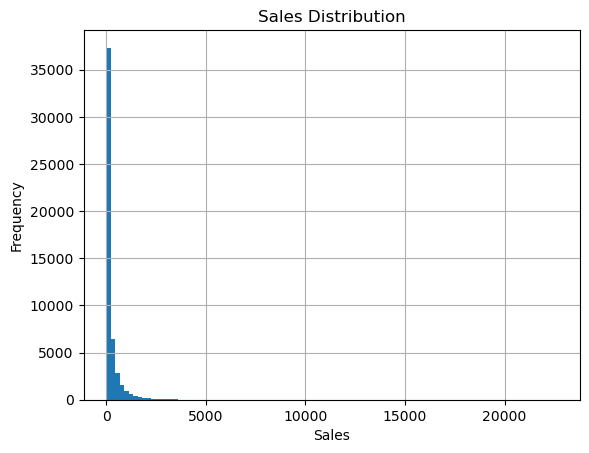

In [14]:
df_clean['Sales'].hist(bins=100)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

In [15]:
outliers = df_clean[(df_clean['Sales'] < Q1 - 3 * IQR) | 
                    (df_clean['Sales'] > Q3 + 3 * IQR)]
print(f"Extreme outliers (3*IQR method): {len(outliers)}")


Extreme outliers (3*IQR method): 3015


In [16]:
top_extreme_outliers = outliers.sort_values(by='Sales', ascending=False).head(20)
print("Top 20 extreme outliers by Sales:")
print(top_extreme_outliers[['Row.ID', 'Sales']])

Top 20 extreme outliers by Sales:
       Row.ID  Sales
47257   33994  22638
27727   38123  17500
28327   39450  14000
48073   33920  11200
27524   35487  10500
3092    40336   9893
2722    35395   9450
27459   35574   9100
28193   39785   8750
46605   37722   8400
361     33802   8188
46282   31462   8160
47388   31980   8000
10129   12069   7959
28430   37923   7000
19939   27720   6999
5186    13560   6517
19901   30958   6440
2143    31806   6355
22933   16681   5785


In [17]:
# Group by Product Name and sum both Sales and Quantity
top_products = top_extreme_outliers.groupby('Product.Name')[['Sales', 'Quantity']].sum()

top_products = top_products.sort_values(by='Sales', ascending=False).head(10)

print("Top 10 products by total sales among extreme outliers:")
print(top_products)



Top 10 products by total sales among extreme outliers:
                                                    Sales  Quantity
Product.Name                                                       
Canon imageCLASS 2200 Advanced Copier               61600        20
Cisco TelePresence System EX90 Videoconferencin...  22638         6
HP Designjet T520 Inkjet Large Format Printer -...  15750         9
GBC Ibimaster 500 Manual ProClick Binding System     9893        13
Ibico EPK-21 Electric Binding System                 9450         5
3D Systems Cube Printer, 2nd Generation, Magenta     9100         7
High Speed Automatic Electric Letter Opener          8188         5
Lexmark MX611dhe Monochrome Laser Printer            8160         8
Cubify CubeX 3D Printer Triple Head Print            8000         4
Hoover Stove, Red                                    7959        14


They are definitely statistical outliers.
But not necessarily wrong.
They could be real large orders (Canon imageCLASS copier )

In [18]:
# Create derived columns

df_clean['Year'] = df_clean['Order.Date'].dt.year
df_clean['Month'] = df_clean['Order.Date'].dt.month
df_clean['Quarter'] = df_clean['Order.Date'].dt.quarter
df_clean['Profit_Margin'] = (df_clean['Profit'] / df_clean['Sales']) * 100
df_clean['Shipping_Time'] = (df_clean['Ship.Date'] - df_clean['Order.Date']).dt.days
df_clean['Day_of_Week'] = df_clean['Order.Date'].dt.dayofweek
df_clean['Month_Name'] = df_clean['Order.Date'].dt.month_name()
df_clean['Discount_Amount'] = df['Sales'] * df['Discount']
df_clean['Revenue_per_Quantity'] = df['Sales'] / df['Quantity']

In [20]:
if 'Sales' in df_clean.columns and 'Profit' in df_clean.columns:
    df_clean['Profit_Margin'] = (df_clean['Profit'] / df_clean['Sales']) * 100
    df_clean['Profit_Margin'] = df_clean['Profit_Margin'].replace([np.inf, -np.inf], 0)
    print("Created Profit_Margin column")

Created Profit_Margin column


In [22]:
# Data validation
print("\nDATA VALIDATION:")
print(f"Date range: {df['Order.Date'].min()} to {df['Order.Date'].max()}")
print(f"Sales range: ${df['Sales'].min():.2f} to ${df['Sales'].max():.2f}")
print(f"Profit range: ${df['Profit'].min():.2f} to ${df['Profit'].max():.2f}")
print(f"Unique customers: {df['Customer.ID'].nunique()}")
print(f"Unique products: {df['Product.ID'].nunique()}")


DATA VALIDATION:
Date range: 2011-01-01 00:00:00.000 to 2014-12-31 00:00:00.000
Sales range: $0.00 to $22638.00
Profit range: $-6599.98 to $8399.98
Unique customers: 4873
Unique products: 10292


In [23]:
cleaning_summary = {
    'original_rows': len(df),
    'cleaned_rows': len(df_clean),
    'rows_removed': len(df) - len(df_clean),
    'columns_count': len(df_clean.columns),
    'missing_values': df_clean.isnull().sum().sum(),
    'date_columns_created': ['Year', 'Month', 'Day_of_Week', 'Month_Name'],
    'derived_columns': ['Profit_Margin']
}

print("CLEANING SUMMARY")
for key, value in cleaning_summary.items():
    print(f"{key}: {value}")

CLEANING SUMMARY
original_rows: 51290
cleaned_rows: 51290
rows_removed: 0
columns_count: 35
missing_values: 0
date_columns_created: ['Year', 'Month', 'Day_of_Week', 'Month_Name']
derived_columns: ['Profit_Margin']


In [24]:
df_clean.head()

,Category,City,Country,Customer.ID,Customer.Name,Discount,Market,è®°å½æ°,Order.Date,Order.ID,...,Market2,weeknum,Month,Quarter,Profit_Margin,Shipping_Time,Day_of_Week,Month_Name,Discount_Amount,Revenue_per_Quantity
0,Office Supplies,Los Angeles,United States,LS-172304,Lycoris Saunders,0.0,US,1,2011-01-07,CA-2011-130813,...,North America,2,1,1,49.111579,2,4,January,0.0,6.333333
1,Office Supplies,Los Angeles,United States,MV-174854,Mark Van Huff,0.0,US,1,2011-01-21,CA-2011-148614,...,North America,4,1,1,48.909474,5,4,January,0.0,9.500000
2,Office Supplies,Los Angeles,United States,CS-121304,Chad Sievert,0.0,US,1,2011-08-05,CA-2011-118962,...,North America,32,8,3,46.865714,4,4,August,0.0,7.000000
3,Office Supplies,Los Angeles,United States,CS-121304,Chad Sievert,0.0,US,1,2011-08-05,CA-2011-118962,...,North America,32,8,3,47.982703,4,4,August,0.0,55.500000
4,Office Supplies,Los Angeles,United States,AP-109154,Arthur Prichep,0.0,US,1,2011-09-29,CA-2011-146969,...,North America,40,9,3,51.840000,4,3,September,0.0,6.000000


In [25]:
# Save cleaned data
df_clean.to_csv('../data/processed/cleaned_data.csv', index=False)